In [35]:
%pip install minisom numpy

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=04df736508b6a5b4c3c4c7fea395338a4957e565343d5a9bfeac60fa3c21155e
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom


In [47]:
# Step 1: Installations and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_blobs
from minisom import MiniSom
import torch
import warnings
warnings.filterwarnings('ignore')

print("PyTorch version:", torch.__version__)
print("GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Generate sample fraud detection dataset
np.random.seed(42)
def generate_fraud_data(n_samples=1000, fraud_ratio=0.1):
    """Generate synthetic fraud detection dataset"""
    # Normal transactions
    n_normal = int(n_samples * (1 - fraud_ratio))
    normal_data = np.random.normal(0, 1, (n_normal, 4))
    normal_labels = np.zeros(n_normal)

    # Fraud transactions (anomalies)
    n_fraud = n_samples - n_normal
    fraud_data = np.random.normal(3, 2, (n_fraud, 4))
    fraud_labels = np.ones(n_fraud)

    # Combine
    data = np.vstack([normal_data, fraud_data])
    labels = np.hstack([normal_labels, fraud_labels])

    # Add some feature names
    feature_names = ['Transaction_Amount', 'Time_of_Day', 'Location_Distance', 'Frequency']

    return data, labels, feature_names

# Generate dataset
X, y, feature_names = generate_fraud_data(1000, 0.1)
print(f"Dataset shape: {X.shape}")
print(f"Fraud cases: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData scaled and ready for SOM training!")

PyTorch version: 2.8.0+cu126
GPU available: True
GPU: Tesla T4
Dataset shape: (1000, 4)
Fraud cases: 100.0 (10.0%)

Data scaled and ready for SOM training!


In [48]:
# Step 2: SOM Implementation with GPU acceleration
class GPUSOM:
    def __init__(self, x=10, y=10, input_len=4, sigma=1.0, learning_rate=0.5, gpu=True):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.gpu = gpu and torch.cuda.is_available()

        # Initialize weights
        self.weights = np.random.rand(x, y, input_len)

        if self.gpu:
            self.weights_tensor = torch.tensor(self.weights, dtype=torch.float32).cuda()
        else:
            self.weights_tensor = torch.tensor(self.weights, dtype=torch.float32)

        # Neighborhood function
        self.neighborhood = np.zeros((x, y))
        for i in range(x):
            for j in range(y):
                self.neighborhood[i, j] = np.exp(-(i**2 + j**2) / (2 * sigma**2))

        if self.gpu:
            self.neighborhood_tensor = torch.tensor(self.neighborhood, dtype=torch.float32).cuda()
        else:
            self.neighborhood_tensor = torch.tensor(self.neighborhood, dtype=torch.float32)

    def find_bmu(self, sample):
        """Find Best Matching Unit using GPU"""
        if self.gpu:
            sample_tensor = torch.tensor(sample, dtype=torch.float32).cuda()
        else:
            sample_tensor = torch.tensor(sample, dtype=torch.float32)

        # Calculate distances using PyTorch for GPU acceleration
        diff = self.weights_tensor - sample_tensor
        distances = torch.sum(diff ** 2, dim=2)

        # Find BMU
        if self.gpu:
            bmu_idx = torch.argmin(distances).cpu().numpy()
        else:
            bmu_idx = torch.argmin(distances).numpy()

        bmu = np.unravel_index(bmu_idx, (self.x, self.y))
        return bmu

    def update_weights(self, sample, bmu, iteration, max_iterations):
        """Update weights using neighborhood function"""
        lr = self.learning_rate * (1 - iteration / max_iterations)

        if self.gpu:
            sample_tensor = torch.tensor(sample, dtype=torch.float32).cuda()
        else:
            sample_tensor = torch.tensor(sample, dtype=torch.float32)

        # Calculate distance from BMU for all neurons
        i_bmu, j_bmu = bmu
        dist_from_bmu = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                dist_from_bmu[i, j] = np.exp(-((i - i_bmu)**2 + (j - j_bmu)**2) / (2 * (self.sigma * (1 - iteration/max_iterations))**2))

        # Update weights
        influence = lr * dist_from_bmu[:, :, np.newaxis]
        if self.gpu:
            influence_tensor = torch.tensor(influence, dtype=torch.float32).cuda()
            update = influence_tensor * (sample_tensor - self.weights_tensor)
            self.weights_tensor += update
            self.weights = self.weights_tensor.cpu().numpy()
        else:
            influence_tensor = torch.tensor(influence, dtype=torch.float32)
            update = influence_tensor * (sample_tensor - self.weights_tensor)
            self.weights_tensor += update
            self.weights = self.weights_tensor.numpy()

    def train(self, data, num_epochs=100):
        """Train the SOM"""
        print(f"Training SOM on {'GPU' if self.gpu else 'CPU'}...")
        for epoch in range(num_epochs):
            if epoch % 20 == 0:
                print(f"Epoch {epoch}/{num_epochs}")

            # Shuffle data
            np.random.shuffle(data)

            for sample in data:
                bmu = self.find_bmu(sample)
                self.update_weights(sample, bmu, epoch, num_epochs)

        print("Training completed!")
        return self.weights

    def distance_map(self):
        """Calculate distance map (U-matrix)"""
        distance_map = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                total_dist = 0
                count = 0
                # Check neighbors
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < self.x and 0 <= nj < self.y:
                        total_dist += np.linalg.norm(self.weights[i,j] - self.weights[ni,nj])
                        count += 1
                distance_map[i,j] = total_dist / count if count > 0 else 0
        return distance_map

    def predict(self, data):
        """Get BMU for each sample"""
        bmus = []
        for sample in data:
            bmu = self.find_bmu(sample)
            bmus.append(bmu)
        return bmus

# Train the SOM
som = GPUSOM(x=15, y=15, input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5)
weights = som.train(X_scaled, num_epochs=100)

Training SOM on GPU...
Epoch 0/100
Epoch 20/100
Epoch 40/100
Epoch 60/100
Epoch 80/100
Training completed!


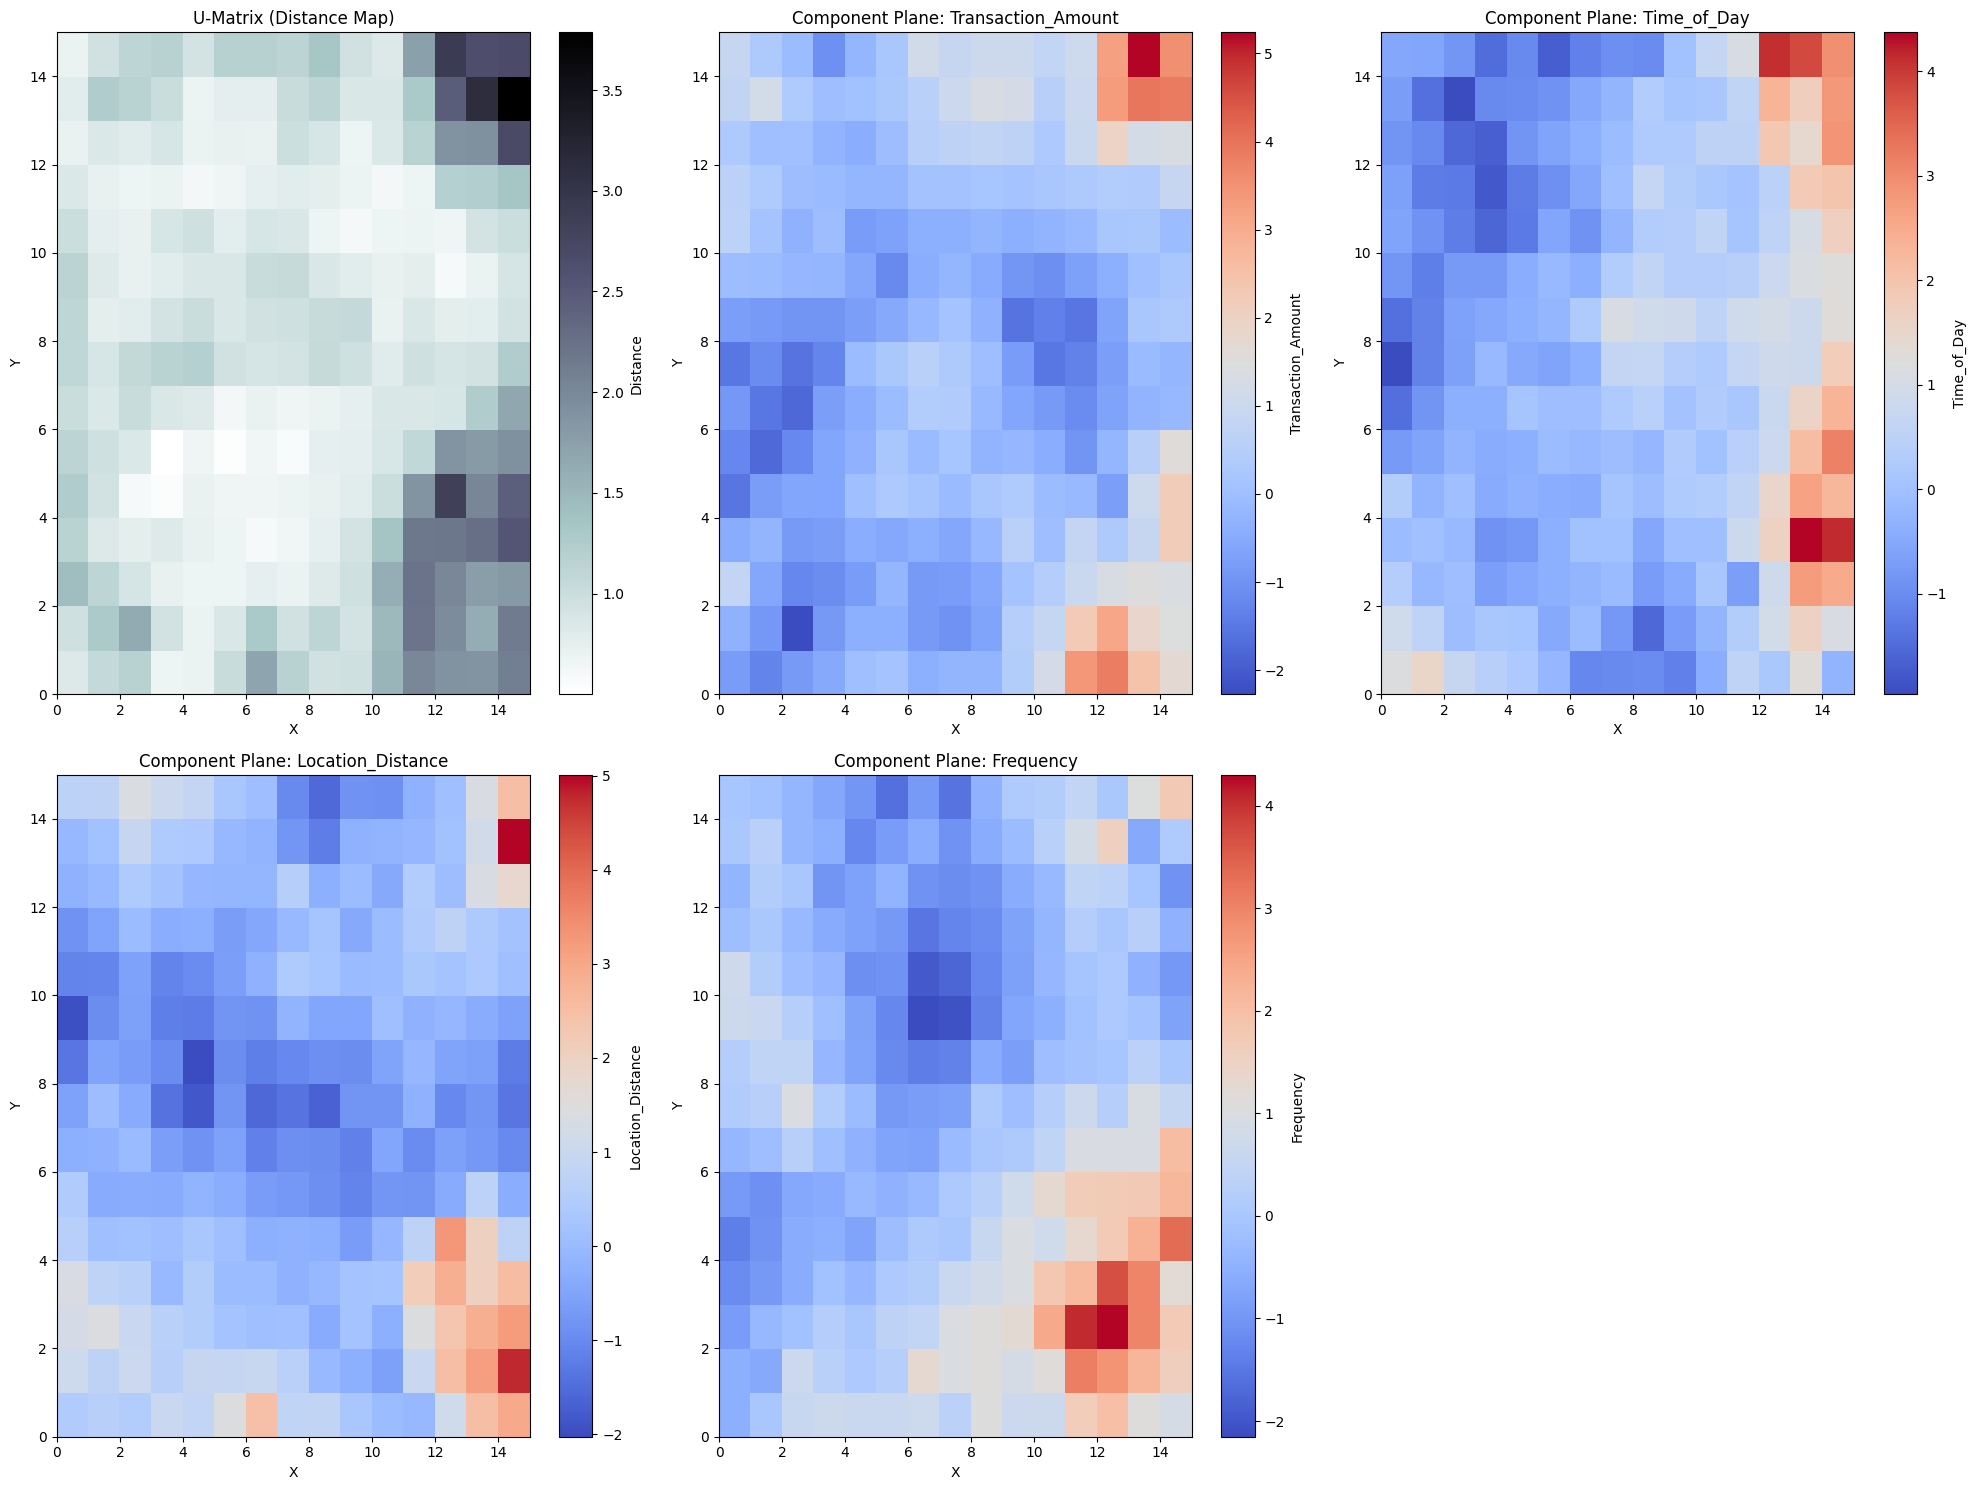

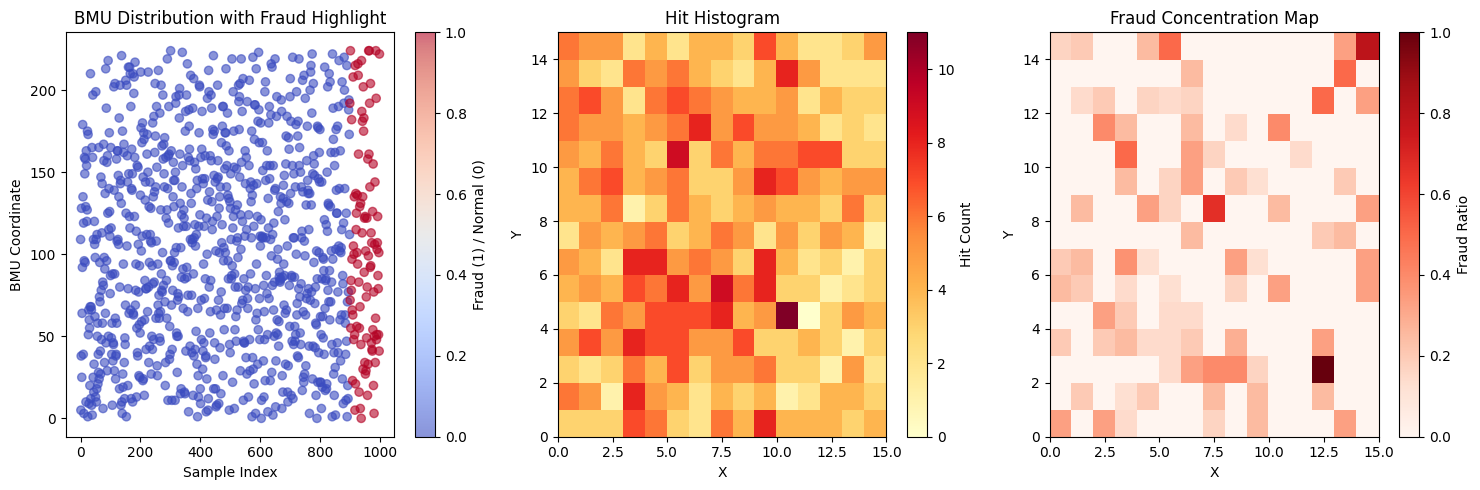

In [49]:
# Step 3: Visualization Techniques
plt.figure(figsize=(20, 15))

# 3.1 U-Matrix Visualization
plt.subplot(2, 3, 1)
u_matrix = som.distance_map()
plt.pcolor(u_matrix.T, cmap='bone_r')
plt.colorbar(label='Distance')
plt.title('U-Matrix (Distance Map)')
plt.xlabel('X')
plt.ylabel('Y')

# 3.2 Component Planes
for i, feature_name in enumerate(feature_names):
    plt.subplot(2, 3, i+2)
    plt.pcolor(weights[:, :, i].T, cmap='coolwarm')
    plt.colorbar(label=feature_name)
    plt.title(f'Component Plane: {feature_name}')
    plt.xlabel('X')
    plt.ylabel('Y')

plt.tight_layout()
plt.show()

# 3.3 Scatter plot with markers for outliers
plt.figure(figsize=(15, 5))

# Get BMUs for all samples
bmus = som.predict(X_scaled)

# Convert BMUs to 1D coordinates for plotting
bmu_coords = [bmu[0] * som.y + bmu[1] for bmu in bmus]

plt.subplot(1, 3, 1)
plt.scatter(range(len(bmu_coords)), bmu_coords, c=y, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Fraud (1) / Normal (0)')
plt.xlabel('Sample Index')
plt.ylabel('BMU Coordinate')
plt.title('BMU Distribution with Fraud Highlight')

# 3.4 Hit histogram
plt.subplot(1, 3, 2)
hit_count = np.zeros((som.x, som.y))
for bmu in bmus:
    hit_count[bmu] += 1

plt.pcolor(hit_count.T, cmap='YlOrRd')
plt.colorbar(label='Hit Count')
plt.title('Hit Histogram')
plt.xlabel('X')
plt.ylabel('Y')

# 3.5 Fraud concentration map
plt.subplot(1, 3, 3)
fraud_count = np.zeros((som.x, som.y))
for i, bmu in enumerate(bmus):
    if y[i] == 1:  # Fraud case
        fraud_count[bmu] += 1

# Normalize by hit count to get fraud ratio
fraud_ratio = np.divide(fraud_count, hit_count, out=np.zeros_like(fraud_count), where=hit_count!=0)
plt.pcolor(fraud_ratio.T, cmap='Reds')
plt.colorbar(label='Fraud Ratio')
plt.title('Fraud Concentration Map')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

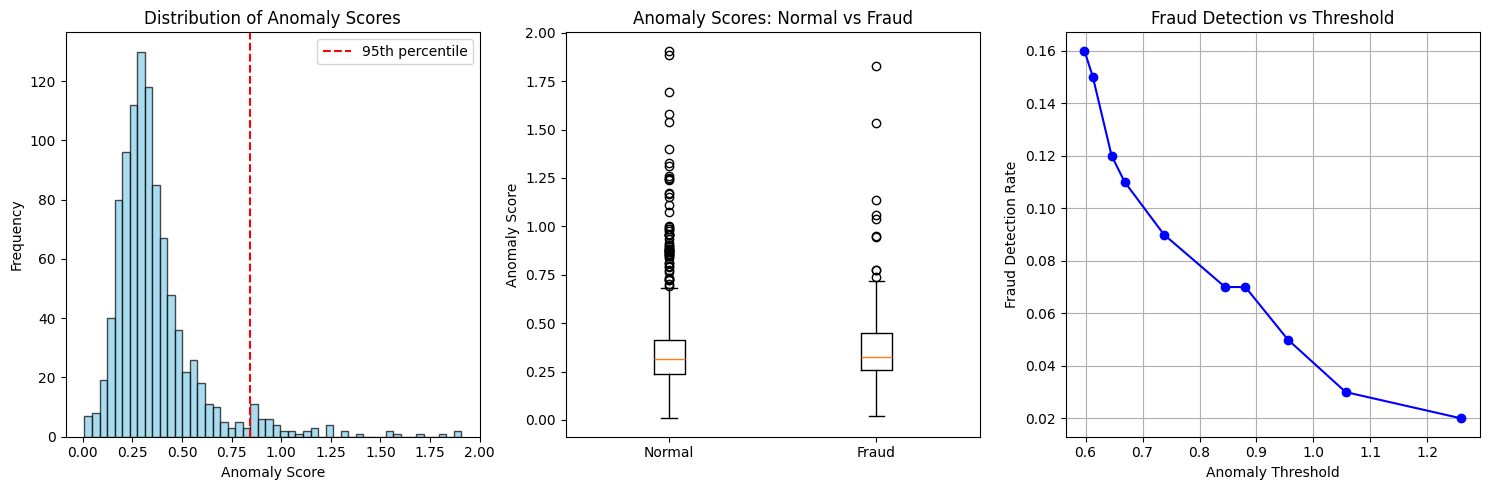

Fraud Detection Performance:
Threshold (95th percentile): 0.8449
Anomalies detected: 50
Actual fraud cases: 100.0

Precision: 0.140
Recall: 0.070
F1-Score: 0.093

Confusion Matrix:
[[857  43]
 [ 93   7]]


In [50]:
# Step 4: Fraud Detection and Anomaly Scoring
def calculate_anomaly_scores(som, data):
    """Calculate anomaly scores based on distance to BMU weights"""
    anomaly_scores = []
    for sample in data:
        bmu = som.find_bmu(sample)
        bmu_weight = som.weights[bmu]
        distance = np.linalg.norm(sample - bmu_weight)
        anomaly_scores.append(distance)
    return np.array(anomaly_scores)

# Calculate anomaly scores
anomaly_scores = calculate_anomaly_scores(som, X_scaled)

# Plot anomaly scores distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(anomaly_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(anomaly_scores, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()

plt.subplot(1, 3, 2)
fraud_scores = anomaly_scores[y == 1]
normal_scores = anomaly_scores[y == 0]
plt.boxplot([normal_scores, fraud_scores], labels=['Normal', 'Fraud'])
plt.ylabel('Anomaly Score')
plt.title('Anomaly Scores: Normal vs Fraud')

plt.subplot(1, 3, 3)
# ROC-like curve for different thresholds
thresholds = np.percentile(anomaly_scores, range(90, 100))
fraud_detection_rates = []
for threshold in thresholds:
    detected_frauds = np.sum((anomaly_scores >= threshold) & (y == 1))
    total_frauds = np.sum(y == 1)
    fraud_detection_rates.append(detected_frauds / total_frauds)

plt.plot(thresholds, fraud_detection_rates, 'bo-')
plt.xlabel('Anomaly Threshold')
plt.ylabel('Fraud Detection Rate')
plt.title('Fraud Detection vs Threshold')
plt.grid(True)

plt.tight_layout()
plt.show()

# Performance metrics
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Set threshold at 95th percentile
threshold = np.percentile(anomaly_scores, 95)
predictions = (anomaly_scores >= threshold).astype(int)

print("Fraud Detection Performance:")
print("=" * 50)
print(f"Threshold (95th percentile): {threshold:.4f}")
print(f"Anomalies detected: {np.sum(predictions)}")
print(f"Actual fraud cases: {np.sum(y)}")

# Calculate metrics
precision, recall, fscore, _ = precision_recall_fscore_support(y, predictions, average='binary')
cm = confusion_matrix(y, predictions)

print(f"\nPrecision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {fscore:.3f}")

print("\nConfusion Matrix:")
print(cm)

Customer Data with SOM Results:
  customer_id    transaction_date  transaction_amount  time_of_day  \
0   CUST_0000 2024-01-01 00:00:00          549.671415    11.170414   
1   CUST_0001 2024-01-01 01:00:00          476.584663    10.595178   
2   CUST_0002 2024-01-01 02:00:00          453.052561    15.255360   
3   CUST_0003 2024-01-01 03:00:00          524.196227     0.520319   
4   CUST_0004 2024-01-01 04:00:00          398.716888    13.885484   
5   CUST_0005 2024-01-01 05:00:00          646.564877    10.645342   
6   CUST_0006 2024-01-01 06:00:00          445.561728    12.665536   
7   CUST_0007 2024-01-01 07:00:00          439.936131    10.249838   
8   CUST_0008 2024-01-01 08:00:00          498.650278     5.653734   
9   CUST_0009 2024-01-01 09:00:00          520.886360     0.241979   

   location_distance  frequency  is_fraud  anomaly_score  som_prediction  \
0         132.384427  20.230299       0.0       0.177984               0   
1         178.960641  12.674347       0.0    

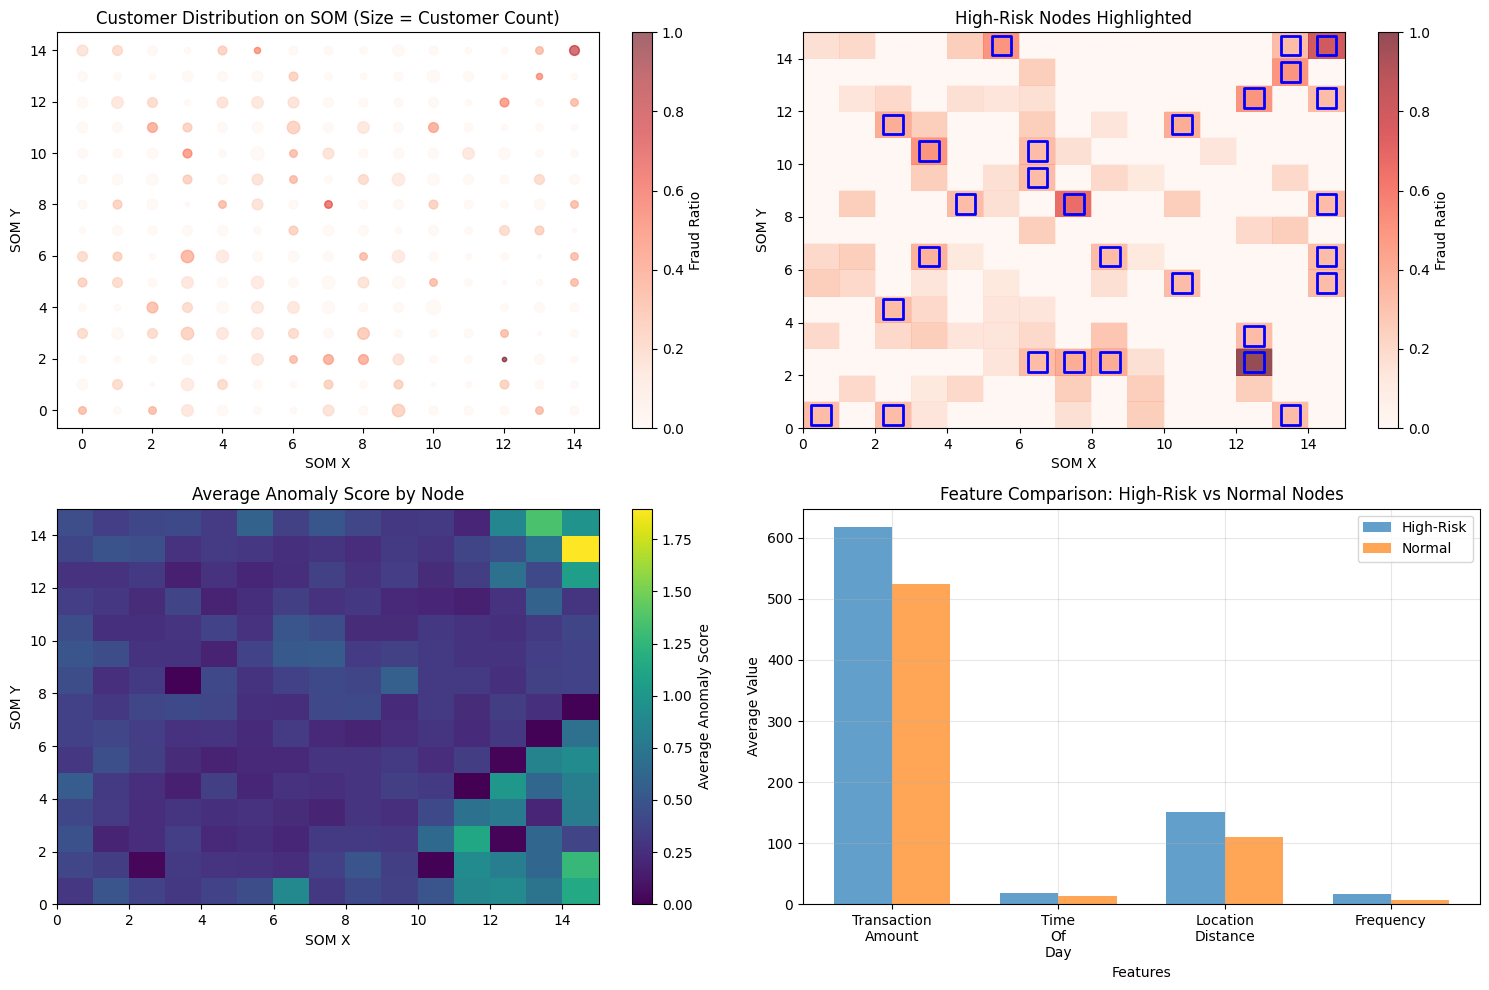


FRAUD DETECTION SUMMARY
Total customers analyzed: 1000
Actual fraud cases: 100.0
Detected anomalies: 50
High-risk SOM nodes identified: 28
Customers in high-risk nodes: 100
Average fraud ratio in high-risk nodes: 0.421


In [52]:
# Step 5: Mapping Back to Customer Data
# Create synthetic customer data to demonstrate the mapping
np.random.seed(42)
n_customers = len(X)
customer_ids = [f'CUST_{i:04d}' for i in range(n_customers)]
transaction_dates = pd.date_range('2024-01-01', periods=n_customers, freq='H')

# Create a DataFrame with customer information
customer_df = pd.DataFrame({
    'customer_id': customer_ids,
    'transaction_date': transaction_dates,
    'transaction_amount': X[:, 0] * 100 + 500,  # Convert to realistic amounts
    'time_of_day': X[:, 1] * 6 + 12,  # Convert to hours
    'location_distance': X[:, 2] * 50 + 100,  # Convert to km
    'frequency': X[:, 3] * 10 + 5,  # Convert to transactions per month
    'is_fraud': y,
    'anomaly_score': anomaly_scores,
    'som_prediction': predictions
})

# Add BMU coordinates
bmu_coords_2d = [(bmu[0], bmu[1]) for bmu in bmus]
customer_df['bmu_x'] = [coord[0] for coord in bmu_coords_2d]
customer_df['bmu_y'] = [coord[1] for coord in bmu_coords_2d]

print("Customer Data with SOM Results:")
print("=" * 60)
print(customer_df.head(10))

# Identify high-risk nodes (clusters with high fraud concentration)
high_risk_threshold = 0.3  # 30% fraud ratio
high_risk_nodes = []

for i in range(som.x):
    for j in range(som.y):
        node_customers = customer_df[(customer_df['bmu_x'] == i) & (customer_df['bmu_y'] == j)]
        if len(node_customers) > 0:
            fraud_ratio_node = node_customers['is_fraud'].mean()
            if fraud_ratio_node > high_risk_threshold:
                high_risk_nodes.append({
                    'node': (i, j),
                    'customers_count': len(node_customers),
                    'fraud_count': node_customers['is_fraud'].sum(),
                    'fraud_ratio': fraud_ratio_node,
                    'avg_anomaly_score': node_customers['anomaly_score'].mean()
                })

high_risk_df = pd.DataFrame(high_risk_nodes)
if not high_risk_df.empty:
    print("\nHigh-Risk SOM Nodes:")
    print("=" * 50)
    print(high_risk_df.sort_values('fraud_ratio', ascending=False))
else:
    print("\nNo high-risk nodes found with the current threshold.")

# Visualization of customer mapping
plt.figure(figsize=(15, 10))

# Plot 1: Customer distribution on SOM
plt.subplot(2, 2, 1)
for i in range(som.x):
    for j in range(som.y):
        node_customers = customer_df[(customer_df['bmu_x'] == i) & (customer_df['bmu_y'] == j)]
        if len(node_customers) > 0:
            plt.scatter(i, j, s=len(node_customers)*10, alpha=0.6,
                       c=node_customers['is_fraud'].mean(), cmap='Reds', vmin=0, vmax=1)
plt.colorbar(label='Fraud Ratio')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.title('Customer Distribution on SOM (Size = Customer Count)')

# Plot 2: High-risk node highlighting
plt.subplot(2, 2, 2)
if not high_risk_df.empty: # Check if high_risk_df is not empty
    # Recalculate fraud_ratio if high_risk_df is not empty
    fraud_ratio_plot = np.zeros((som.x, som.y))
    for i in range(som.x):
        for j in range(som.y):
            node_customers = customer_df[(customer_df['bmu_x'] == i) & (customer_df['bmu_y'] == j)]
            if len(node_customers) > 0:
                fraud_ratio_plot[i,j] = node_customers['is_fraud'].mean()

    plt.pcolor(fraud_ratio_plot.T, cmap='Reds', alpha=0.7)
    plt.colorbar(label='Fraud Ratio')
    # Mark high-risk nodes
    for _, row in high_risk_df.iterrows():
        node = row['node']
        plt.scatter(node[0] + 0.5, node[1] + 0.5, s=200, facecolors='none',
                   edgecolors='blue', linewidth=2, marker='s', label='High-Risk' if node == high_risk_df.iloc[0]['node'] else "")
    plt.title('High-Risk Nodes Highlighted')
    plt.xlabel('SOM X')
    plt.ylabel('SOM Y')
else:
    plt.title('No High-Risk Nodes to Highlight')
    plt.xlabel('SOM X')
    plt.ylabel('SOM Y')


# Plot 3: Anomaly scores by node
plt.subplot(2, 2, 3)
node_anomaly = np.zeros((som.x, som.y))
for i in range(som.x):
    for j in range(som.y):
        node_customers = customer_df[(customer_df['bmu_x'] == i) & (customer_df['bmu_y'] == j)]
        if len(node_customers) > 0:
            node_anomaly[i, j] = node_customers['anomaly_score'].mean()
plt.pcolor(node_anomaly.T, cmap='viridis')
plt.colorbar(label='Average Anomaly Score')
plt.title('Average Anomaly Score by Node')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')

# Plot 4: Feature analysis for high-risk nodes
plt.subplot(2, 2, 4)
if not high_risk_df.empty:
    high_risk_customers = customer_df[
        customer_df.apply(lambda row: (row['bmu_x'], row['bmu_y']) in high_risk_df['node'].tolist(), axis=1)
    ]

    features_to_plot = ['transaction_amount', 'time_of_day', 'location_distance', 'frequency']
    feature_means = []
    categories = ['High-Risk', 'Normal']

    high_risk_means = high_risk_customers[features_to_plot].mean().values
    normal_means = customer_df[~customer_df.index.isin(high_risk_customers.index)][features_to_plot].mean().values

    x = np.arange(len(features_to_plot))
    width = 0.35

    plt.bar(x - width/2, high_risk_means, width, label='High-Risk', alpha=0.7)
    plt.bar(x + width/2, normal_means, width, label='Normal', alpha=0.7)

    plt.xlabel('Features')
    plt.ylabel('Average Value')
    plt.title('Feature Comparison: High-Risk vs Normal Nodes')
    plt.xticks(x, [f.replace('_', '\n').title() for f in features_to_plot])
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.title('No High-Risk Nodes for Feature Analysis')
    plt.xlabel('Features')
    plt.ylabel('Average Value')


plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("FRAUD DETECTION SUMMARY")
print("="*60)
print(f"Total customers analyzed: {len(customer_df)}")
print(f"Actual fraud cases: {customer_df['is_fraud'].sum()}")
print(f"Detected anomalies: {customer_df['som_prediction'].sum()}")
print(f"High-risk SOM nodes identified: {len(high_risk_nodes)}")

if not high_risk_df.empty:
    total_high_risk_customers = sum([row['customers_count'] for row in high_risk_nodes])
    print(f"Customers in high-risk nodes: {total_high_risk_customers}")
    print(f"Average fraud ratio in high-risk nodes: {high_risk_df['fraud_ratio'].mean():.3f}")